In [1]:
import os, shutil
import subprocess as subp
import numpy as np
import mdtraj
import matplotlib.pyplot as plt

In [116]:
# number of simulations per epoch
N = 16
gmx = "gmx"

# input files for grompping
mdp   = "mdrun.mdp"
topol = "topol.top"
ndx   = "index_grompp.ndx"

# sbatch template variables
email= "santeri.e.paajanen@helsinki.fi"
account="project_2004581"

In [3]:
def gromacs_command(cmd, *args, input=None, **kwargs):
    """ Call the gromacs subcommand cmd. Both args and keys of kwargs should be without the leading dash.
        output is redirected to output_<cmd>.txt.
    """
    command = [gmx, cmd]+["-"+a for a in args]
    for k in kwargs:
        command += ["-"+k, kwargs[k]]
    
    with open("output_%s.txt"%cmd, "w") as fout:
        compProc = subp.run(command, stdout=fout, stderr=subp.STDOUT, input=input)
    
    return compProc.returncode

def init_rep(i):
    """ Initializes rep i
    """
    os.makedirs("epoch01/rep%02d"%i)
    
    # If not found, just load the default
    shutil.copyfile("initial/start.gro", "epoch01/rep%02d/start.gro"%i)
    print("Copied initial/start.gro to rep%02d, starting to grompp..."%i)

    # Save original working dir to come back to
    prevdir = os.getcwd()
    try:
        os.chdir("epoch01/rep%02d"%i)

        rc=gromacs_command("grompp", c="start.gro", f="../../"+mdp, n="../../"+ndx,
                           p="../../"+topol, o="mdrun.tpr", maxwarn="1")

        print("Process returned %d"%rc)

    finally:
        # Whatever happens, we go back to the original working dir
        os.chdir(prevdir)

In [4]:
# Make a pdb file for mdtraj
prevdir = os.getcwd()
try:
    os.chdir("initial")

    rc = gromacs_command("trjconv", f="start.gro", s="start.gro", o="start.pdb", input=b"0\n")
    print("Process returned %d"%rc)
finally:
    os.chdir(prevdir)

Process returned 0


In [5]:
# Initial structures and first epoch
os.makedirs("epoch01", exist_ok=True)

for i in range(1,N+1):
    init_rep(i)

Copied initial/start.gro to rep01, starting to grompp...
Process returned 0
Copied initial/start.gro to rep02, starting to grompp...
Process returned 0
Copied initial/start.gro to rep03, starting to grompp...
Process returned 0
Copied initial/start.gro to rep04, starting to grompp...
Process returned 0
Copied initial/start.gro to rep05, starting to grompp...
Process returned 0
Copied initial/start.gro to rep06, starting to grompp...
Process returned 0
Copied initial/start.gro to rep07, starting to grompp...
Process returned 0
Copied initial/start.gro to rep08, starting to grompp...
Process returned 0
Copied initial/start.gro to rep09, starting to grompp...
Process returned 0
Copied initial/start.gro to rep10, starting to grompp...
Process returned 0
Copied initial/start.gro to rep11, starting to grompp...
Process returned 0
Copied initial/start.gro to rep12, starting to grompp...
Process returned 0
Copied initial/start.gro to rep13, starting to grompp...
Process returned 0
Copied initi

In [17]:
############################## User input ############################
# To save memory we only load this selection
# mdtraj selection string https://www.mdtraj.org/1.9.5/atom_selection.html
select_str = "protein and residue 638 and not (name =~ 'H.*')"

# Minimum and maximum values to sample from between. None to ignore boundary, "start" string to use the
# initial value of the starting structure
minval=None
maxval="start"


def function_val(positions):
    """
      Write here your analysis function. Positions will be
        numpy array of shape (n,m,3) for n frames of m atoms.
        Note that m is the number of atoms in the selection,
        not the whole trajectory.
      The function should return a numpy array of shape (n).
    """
    m = positions.shape[-2]
    # 4 residues match, so we separate them
    m_res = m//4
    # selections for each res
    ind1 = np.array(list(range(m_res)))
    ind2 = m_res+ind1
    ind3 = m_res+ind2
    ind4 = m_res+ind3
    
    # distances between average position of res1 to average position of res3
    dist1 = np.linalg.norm(np.mean(positions[:,ind1,:], axis=-2)-np.mean(positions[:,ind3,:], axis=-2), axis=-1)
    # same for res 2 and 4
    dist2 = np.linalg.norm(np.mean(positions[:,ind2,:], axis=-2)-np.mean(positions[:,ind4,:], axis=-2), axis=-1)
    
    return np.minimum(dist1, dist2)



############################## User input ############################

In [103]:
load_fval = False # set to True to recalculate analysis even if fval.npy is present
epoch_dir = "" # set if current dir is not the dir with the epoch-directories (and initial-dir)

def load_data(struct, sel, epoch):
    fval = []
    for i in range(1,N+1):
        d = epoch_dir+"epoch%02d/rep%02d/"%(epoch, i)
        if(not load_fval):
            try:
                fval.append(np.load(d+"fval.npy"))
                print("Loaded fval from %sfval.npy"%d)
                continue
            except FileNotFoundError:
                print("Could not open %s"%(d+"fval.npy"))
                
        print("Loading trajectory %s"%(d+"mdrun.xtc"))
        traj = mdtraj.load(d+"mdrun.xtc", top=struct,atom_indices=sel)
        print("Calculating fval")
        fval.append(function_val(traj.xyz))
        print("Saving fval")
        np.save(d+"fval.npy", fval[-1])
    
    reps = [np.full(f.shape,i+1) for i,f in enumerate(fval)]
    frms = [np.arange(len(f)) for f in fval]
    
    return np.concatenate(reps), np.concatenate(fval), np.concatenate(frms)

In [18]:
print("Loading structure and making selection")
struct = mdtraj.load(epoch_dir+"initial/start.pdb")
sel = struct.topology.select(select_str)

startval = function_val(struct.xyz[:,sel,:])

# Min and maxvals
if(minval=="start"):
    minval=startval
elif(minval is None):
    minval=-np.inf

if(maxval=="start"):
    maxval=startval
elif(minval is None):
    maxval=np.inf


print("Selected %d atoms"%len(sel))

Loading structure and making selection
Selected 28 atoms


In [104]:
epochs = 1
fval = []
reps = []
frms = []
for i in range(1,epochs+1):
    r,f,fr = load_data(struct, sel, i)
    reps.append(r)
    fval.append(f)
    frms.append(fr)

    
epcs = [np.full(f.shape,i+1) for i,f in enumerate(fval)]

reps = np.concatenate(reps)
fval = np.concatenate(fval)
epcs = np.concatenate(epcs)
frms = np.concatenate(frms)

Loaded fval from epoch01/rep01/fval.npy
Loaded fval from epoch01/rep02/fval.npy
Loaded fval from epoch01/rep03/fval.npy
Loaded fval from epoch01/rep04/fval.npy
Loaded fval from epoch01/rep05/fval.npy
Loaded fval from epoch01/rep06/fval.npy
Loaded fval from epoch01/rep07/fval.npy
Loaded fval from epoch01/rep08/fval.npy
Loaded fval from epoch01/rep09/fval.npy
Loaded fval from epoch01/rep10/fval.npy
Loaded fval from epoch01/rep11/fval.npy
Loaded fval from epoch01/rep12/fval.npy
Loaded fval from epoch01/rep13/fval.npy
Loaded fval from epoch01/rep14/fval.npy
Loaded fval from epoch01/rep15/fval.npy
Loaded fval from epoch01/rep16/fval.npy


9931
[1.165798] 0.74376255 8412 84 0.0072260818311146325


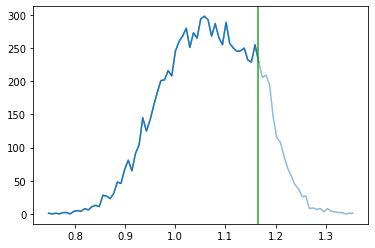

In [105]:
print(len(fval))
_largest_val = np.max(fval)
_lowest_val  = np.min(fval)
_binmax = min(_largest_val, maxval)
_binmin = max(_lowest_val,  minval)
_maxbins = np.sum((fval>minval)*(fval<maxval))//100
_binsize = (_largest_val-_lowest_val)/min(_maxbins,100)
print(_binmax,_binmin, np.sum((fval>minval)*(fval<maxval)),_maxbins,_binsize)
bin_edges = np.arange(_lowest_val,_largest_val+_binsize , _binsize)
hist, bin_edges = np.histogram(fval, bins=bin_edges)
bin_centers = (bin_edges[:-1]+bin_edges[1:])/2
# higher edge larger than minval AND lower edge lower than maxval
mask = (bin_edges[1:]>minval)*(bin_edges[:-1]<maxval)


plt.plot(bin_centers, hist, color="C0", alpha=0.5)
plt.plot(bin_centers[mask], hist[mask], color="C0")
plt.axvline(startval, color="C2")
plt.show()


[ 4 13  2 18  8 21 12 17  4 16 16 56  0 22  7 11]


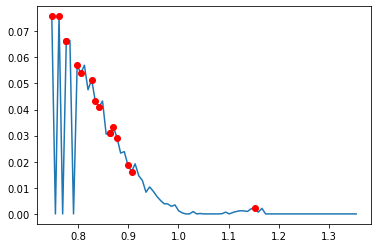

In [106]:
_prob_mask = mask*(hist!=0)
_hmax = np.max(hist[_prob_mask])*0.9
_prob_mask *= hist<_hmax
_hmin = np.min(hist[_prob_mask])

_probs = np.log(1/(np.where(hist==0, 1,hist)/np.max(hist[_prob_mask])))*_prob_mask
_probs = np.where(hist==0, 0,_probs)
_probs /= np.sum(_probs)
plt.plot(bin_centers, _probs)

_rng = np.random.default_rng()
_choices = _rng.choice(len(hist), size=N, p=_probs)
print(_choices)
plt.plot(bin_centers[_choices], _probs[_choices], "ro")

plt.show()

[ 0  2 16 14 20 19 18 13  8  4 19 17  4 28  4  0]


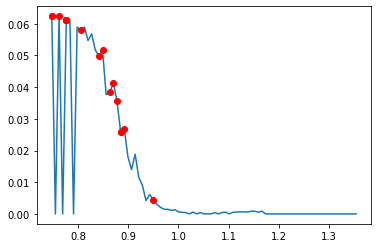

In [107]:
_prob_mask = mask*(hist!=0)
_hmax = np.max(hist[_prob_mask])*0.9
_prob_mask *= hist<_hmax
_hmin = np.min(hist[_prob_mask])

# the "energy" of the highest point of the barrier, in kbt
_barrier = 5
_probs = np.exp(-(hist-_hmin)/(_hmax-_hmin)*_barrier)*_prob_mask
_probs /= np.sum(_probs)
plt.plot(bin_centers, _probs)

_rng = np.random.default_rng()
_choices = _rng.choice(len(hist), size=N, p=_probs)
print(_choices)
chosen_bins = _choices
plt.plot(bin_centers[_choices], _probs[_choices], "ro")

plt.show()

[ 4 20  7  9 10  2 21  7 14 32 12 32  4 22 15  9]


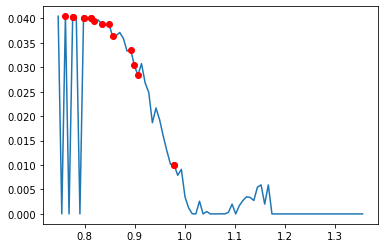

In [108]:
_prob_mask = mask*(hist!=0)
_hmax = np.max(hist[_prob_mask])*0.9
_prob_mask *= hist<_hmax
_hmin = np.min(hist[_prob_mask])

_probs = ((_hmax-hist)/(_hmax-_hmin)) *_prob_mask
_probs /= np.sum(_probs)
plt.plot(bin_centers, _probs)

_rng = np.random.default_rng()
_choices = _rng.choice(len(hist), size=N, p=_probs)
print(_choices)
plt.plot(bin_centers[_choices], _probs[_choices], "ro")

plt.show()

In [118]:
def choose_frames(chosen_bins):
    global bin_edges, fval, epcs, reps, frms
    _rng = np.random.default_rng()
    # lists for value, rpoch, rep and frame
    v,e,r,f=[],[],[],[]
    for bi in chosen_bins:
        vals_in_bin = (fval >= bin_edges[bi])*(fval < bin_edges[bi+1])
        ndx = _rng.choice(np.sum(vals_in_bin))
        v.append(fval[vals_in_bin][ndx])
        e.append(epcs[vals_in_bin][ndx])
        r.append(reps[vals_in_bin][ndx])
        f.append(frms[vals_in_bin][ndx])
    
    return np.array(fval), np.array(e), np.array(r), np.array(f)


def next_rep(i,newepoch,oldepoch,rep,frm):
    """ Initializes rep i of newepoch, taking the frame frm from rep of oldepoch
    """
    global struct
    os.makedirs("epoch%02d/rep%02d"%(newepoch, i))
    
    print("Reading frame %d of epoch %d, rep %d"%(frm, oldepoch, rep))
    init_struct = mdtraj.load_frame("epoch%02d/rep%02d/mdrun.xtc"%(oldepoch, rep), frm, top=struct)
    
    init_struct.save_gro("epoch%02d/rep%02d/start.gro"%(newepoch, i))
    print("Wrote structure to epoch%02d/rep%02d/start.gro, starting to grompp..."%(newepoch, i))
    
    # Make a note of the origin
    with open("epoch%02d/rep%02d/origin.txt"%(newepoch, i), "w") as f:
        f.write("# Origin of this trajectory:\n")
        f.write("# epoch rep frame\n")
        f.write("%d %d %d\n"%(oldepoch,rep,frm))
        
    # copy sbatch template
    with open("templates/sbatch_launch.sh") as fin:
        with open("epoch%02d/sbatch_launch.sh"%newepoch, "w") as fout:
            fout.write(fin.read().format(i=newepoch, account=account, email=email))

    # Save original working dir to come back to
    prevdir = os.getcwd()
    try:
        os.chdir("epoch%02d/rep%02d"%(newepoch, i))
        
        # The pdb structure seems to change the atom names, so maxwarn is 2
        rc=gromacs_command("grompp", c="start.gro", f="../../"+mdp, n="../../"+ndx,
                           p="../../"+topol, o="mdrun.tpr", maxwarn="2")

        print("Process returned %d"%rc)

    finally:
        # Whatever happens, we go back to the original working dir
        os.chdir(prevdir)

In [119]:
nextepoch = 2

v, e, r, f = choose_frames(chosen_bins)
print(v, e, r, f)

for i, (epoch, rep, frm) in enumerate(zip(e,r,f)):
    next_rep(i+1, nextepoch, epoch, rep, frm)

[1.1658626 1.2282704 1.257935  ... 1.085065  1.0691016 1.1071081] [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1] [10 10  8  6  6  8 13  6  6 10  6  8 10  6 10 10] [311 314 126 648 652 284 454 609 339 328 551 220 281 425 328 311]
Reading frame 311 of epoch 1, rep 10
Wrote structure to epoch02/rep01/start.gro, starting to grompp...
Process returned 0
Reading frame 314 of epoch 1, rep 10
Wrote structure to epoch02/rep02/start.gro, starting to grompp...
Process returned 0
Reading frame 126 of epoch 1, rep 8
Wrote structure to epoch02/rep03/start.gro, starting to grompp...
Process returned 0
Reading frame 648 of epoch 1, rep 6
Wrote structure to epoch02/rep04/start.gro, starting to grompp...
Process returned 0
Reading frame 652 of epoch 1, rep 6
Wrote structure to epoch02/rep05/start.gro, starting to grompp...
Process returned 0
Reading frame 284 of epoch 1, rep 8
Wrote structure to epoch02/rep06/start.gro, starting to grompp...
Process returned 0
Reading frame 454 of epoch 1, rep 13
Wrote structure to 